In [2]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split

In [3]:
# Add an additional column, mapping to the type
df = pd.read_csv(r'dataset/output.csv')

diagnosis_dict_binary = {
    0: 'Erythrodermic',
    1: 'Guttate',
    2: 'Inverse',
    3: 'Nail',
    4: 'Plaque',
    5: 'Pustular',
    6: 'Normal'
}

diagnosis_dict = {
    0: 'Erythrodermic',
    1: 'Guttate',
    2: 'Inverse',
    3: 'Nail',
    4: 'Plaque',
    5: 'Pustular',
    6: 'Normal'
}


df['binary_type'] =  df['type'].map(diagnosis_dict_binary.get)
df['type'] = df['type'].map(diagnosis_dict.get)
df.head()

id_code           type    binary_type
0  aitcsdtqap  Erythrodermic  Erythrodermic
1  akpamjetze  Erythrodermic  Erythrodermic
2  aonnhzxqvg  Erythrodermic  Erythrodermic
3  arsqdqvonv  Erythrodermic  Erythrodermic
4  atzkvuaahb  Erythrodermic  Erythrodermic

<Axes: ylabel='type'>

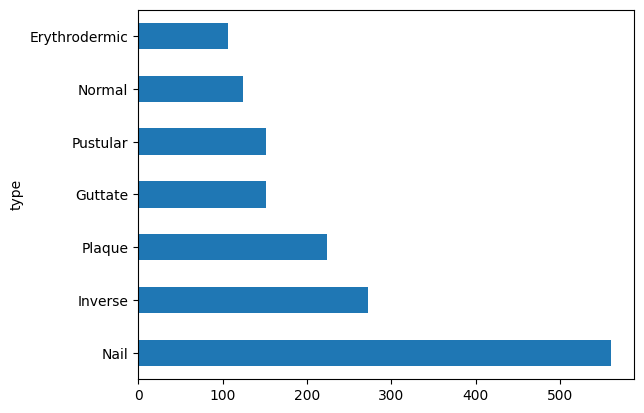

In [4]:
df['type'].value_counts().plot(kind='barh')

<Axes: ylabel='binary_type'>

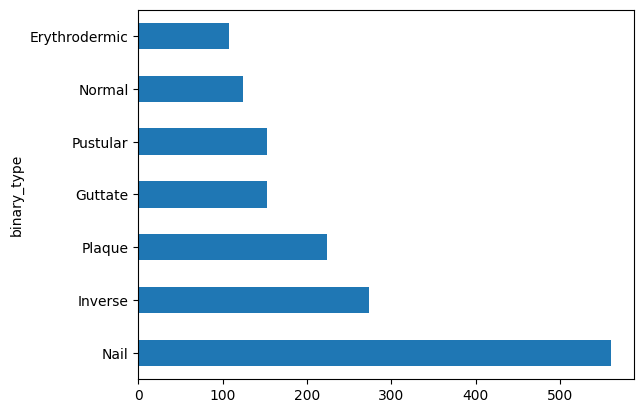

In [5]:
df['binary_type'].value_counts().plot(kind='barh')

In [6]:
# Split into stratified train, val, and test sets
train_intermediate, val = train_test_split(df, test_size=0.15, stratify=df['type'])

# Calculate the proportion of data to be allocated to the test set
test_proportion = 0.1  # For example, you can reduce the test size to 10%

# Split the remaining data into train and test with test_proportion
train, test = train_test_split(train_intermediate, test_size=test_proportion, stratify=train_intermediate['type'])

print(train['type'].value_counts(), '\n')
print(test['type'].value_counts(), '\n')
print(val['type'].value_counts(), '\n')

type
Nail             428
Inverse          209
Plaque           171
Guttate          116
Pustular         116
Normal            95
Erythrodermic     82
Name: count, dtype: int64 

type
Nail             48
Inverse          23
Plaque           19
Pustular         13
Guttate          13
Normal           11
Erythrodermic     9
Name: count, dtype: int64 

type
Nail             84
Inverse          41
Plaque           34
Guttate          23
Pustular         23
Normal           18
Erythrodermic    16
Name: count, dtype: int64 



In [7]:
# Create working directories for train/val/test
base_dir = ''

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)

In [8]:
src_dir = r'dataset'

for index, row in train.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".JPG"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(train_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok=True)
    try:
        shutil.copy(srcfile, dstfile)
    except FileNotFoundError:
        print(f"File not found: {srcfile}")

for index, row in val.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".JPG"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(val_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok=True)
    try:
        shutil.copy(srcfile, dstfile)
    except FileNotFoundError:
        print(f"File not found: {srcfile}")
 
for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".JPG"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(test_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok=True)
    try:
        shutil.copy(srcfile, dstfile)
    except FileNotFoundError:
        print(f"File not found: {srcfile}")


File not found: dataset\Plaque\pzxmqypdsv.JPG
File not found: dataset\Plaque\kddspwqarv.JPG
File not found: dataset\Guttate\elpxedcoqv.JPG
File not found: dataset\Guttate\vwhsazcjmm.JPG
File not found: dataset\Guttate\ssbudeuyeb.JPG
File not found: dataset\Guttate\pdhygdmmbu.JPG
File not found: dataset\Guttate\avmikgfonq.JPG
File not found: dataset\Guttate\djezgexfhu.JPG
File not found: dataset\Plaque\cfqzuamvev.JPG
File not found: dataset\Plaque\kotynepsmo.JPG
File not found: dataset\Plaque\zjoviqmhpf.JPG
File not found: dataset\Plaque\enkhpjpckp.JPG
File not found: dataset\Guttate\prpipfqepf.JPG
File not found: dataset\Plaque\dmoonpyfwn.JPG
File not found: dataset\Pustular\cjvckmeaps.JPG
File not found: dataset\Guttate\actfdclunf.JPG
File not found: dataset\Guttate\vqhcddxmti.JPG
File not found: dataset\Plaque\rhrgjsvitx.JPG
File not found: dataset\Pustular\muwzkjuxqz.JPG
File not found: dataset\Plaque\yswqnbgskk.JPG
File not found: dataset\Guttate\vldkjnhoad.JPG
File not found: data

In [9]:
# Setting up ImageDataGenerator for train/val/test 

train_path = 'train'
val_path = 'val'
test_path = 'test'

train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_path, target_size=(224,224), shuffle = True)
val_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(val_path, target_size=(224,224), shuffle = True)
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, target_size=(224,224), shuffle = False)

Found 1048 images belonging to 7 classes.


Found 208 images belonging to 7 classes.
Found 115 images belonging to 7 classes.


In [10]:
# Building the model

model = tf.keras.Sequential([
    layers.Conv2D(8, (3,3), padding="valid", input_shape=(224,224,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(16, (3,3), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(32, (4,4), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
 
    layers.Flatten(),
    layers.Dense(32, activation = 'relu'),
    layers.Dropout(0.15),
    layers.Dense(7, activation = 'softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])

history = model.fit(train_batches,
                    epochs=30,
                    validation_data=val_batches)

Epoch 1/30



33/33 [==============================] - 30s 815ms/step - loss: 0.8635 - acc: 0.2853 - val_loss: 0.5502 - val_acc: 0.1971
Epoch 2/30
33/33 [==============================] - 14s 427ms/step - loss: 0.5134 - acc: 0.4752 - val_loss: 0.5012 - val_acc: 0.1923
Epoch 3/30
33/33 [==============================] - 14s 414ms/step - loss: 0.3931 - acc: 0.5582 - val_loss: 0.4573 - val_acc: 0.0865
Epoch 4/30
33/33 [==============================] - 13s 390ms/step - loss: 0.3064 - acc: 0.6374 - val_loss: 0.5864 - val_acc: 0.1635
Epoch 5/30
33/33 [==============================] - 25s 778ms/step - loss: 0.2357 - acc: 0.7271 - val_loss: 0.6223 - val_acc: 0.0769
Epoch 6/30
33/33 [==============================] - 43s 1s/step - loss: 0.1917 - acc: 0.7891 - val_loss: 0.5565 - val_acc: 0.2163
Epoch 7/30
33/33 [==============================] - 48s 1s/step - loss: 0.1700 - acc: 0.8302 - val_loss: 0.6467 - val_acc: 0.1923
Epoch 8/30
33/33 [==============================] - 34s 1s/step - loss: 0.1353 - acc: 

In [11]:
model.save('64x3-CNN.model')

INFO:tensorflow:Assets written to: 64x3-CNN.model\assets


INFO:tensorflow:Assets written to: 64x3-CNN.model\assets


In [12]:
loss, acc = model.evaluate_generator(test_batches, verbose=1)
# print("Loss: ", loss)
print("Accuracy: ", acc)

C:\Users\MAITHILI\AppData\Local\Temp\ipykernel_26484\3368063525.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, acc = model.evaluate_generator(test_batches, verbose=1)


4/4 [==============================] - 4s 1s/step - loss: 0.6295 - acc: 0.5391
Accuracy:  0.539130449295044


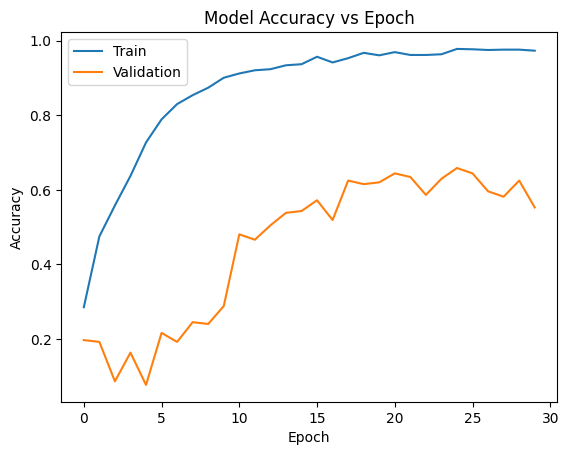

In [13]:
import matplotlib.pyplot as plt
 # Assuming you have already trained the model and stored the history object 
# Plot training & validation accuracy values
plt.plot(history.history['acc']) 
plt.plot(history.history['val_acc']) 
plt.title('Model Accuracy vs Epoch') 
plt.xlabel('Epoch') 
plt.ylabel('Accuracy') 
plt.legend(['Train', 'Validation'], loc='upper left') 
plt.show()


In [14]:
import cv2

In [15]:
def predict_class(path):
    img = cv2.imread(path)

    RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    RGBImg= cv2.resize(RGBImg,(224,224))
    plt.imshow(RGBImg)
    image = np.array(RGBImg) / 255.0
    new_model = tf.keras.models.load_model("64x3-CNN.model")
    predict=new_model.predict(np.array([image]))
    per=np.argmax(predict,axis=1)
    print(per)

1/1 [==============================] - 0s 379ms/step
[0]


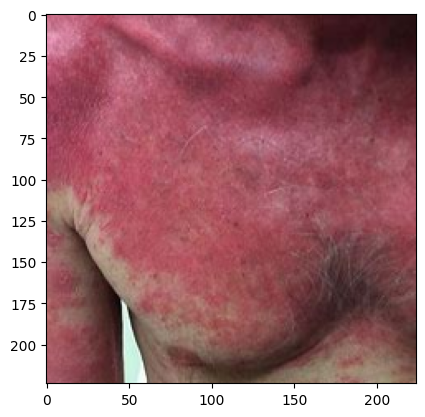

In [16]:
predict_class('dataset/Erythrodermic/aitcsdtqap.JPG')

1/1 [==============================] - 0s 234ms/step
[3]


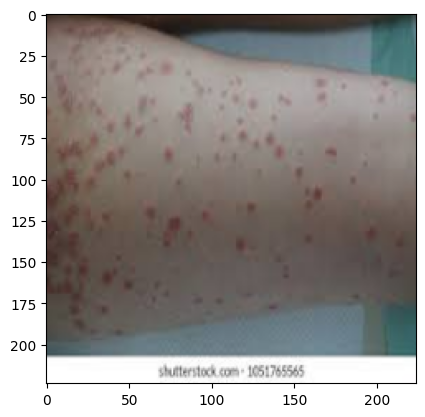

In [17]:
predict_class('dataset/Guttate/actfdclunf.JPEG')

In [18]:
def predict_class(path):
    img = cv2.imread(path)

    RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    RGBImg= cv2.resize(RGBImg,(224,224))
    plt.imshow(RGBImg)
    image = np.array(RGBImg) / 255.0
    new_model = tf.keras.models.load_model("64x3-CNN.model")
    predict=new_model.predict(np.array([image]))
    per=np.argmax(predict,axis=1)
    if per == 0:
        print('Erythrodermic')
    if per == 1:
        print('Guttate')
    if per == 2:
        print('Inverse')
    if per == 3:
        print('Nail')
    if per == 4:
        print('Plaque')
    if per == 5:
        print('Pustular')
    if per == 6:
        print('Normal')

1/1 [==============================] - 0s 290ms/step
Nail


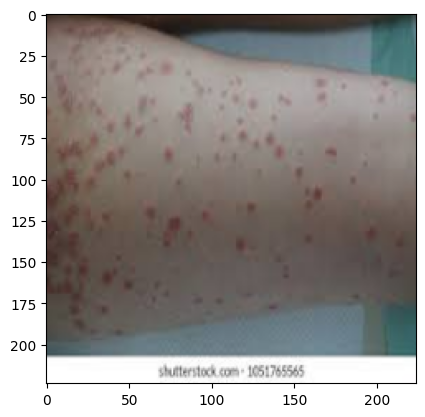

In [19]:
predict_class('dataset/Guttate/actfdclunf.JPEG')

1/1 [==============================] - 0s 253ms/step
Erythrodermic


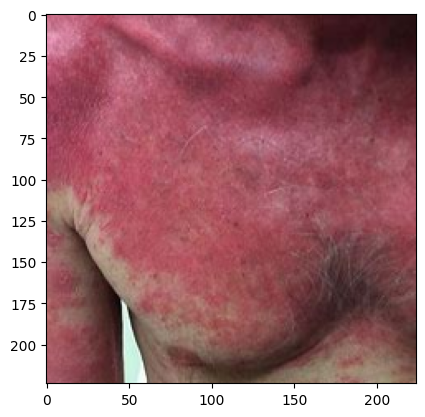

In [20]:
predict_class('dataset/Erythrodermic/aitcsdtqap.JPG')